# CLIP Vector Search & Clustering Feasibility Study

This notebook evaluates the practicality of using CLIP embeddings for the media search workflow outlined in `docs/mvp_backend_design.md`. We focus on text-to-image retrieval and automatic clustering with CPU-only inference to mirror the hackathon deployment constraints.


## Setup Checklist

- Stick to CPU-only execution to mirror hackathon constraints.
- Drop real photos under `notebooks/images/` (optionally grouped into subfolders such as `cats/`, `dogs/`, `cars/`, `fruits/`).
- Reuse the shared CLIP checkpoint for zero-shot text/image embeddings.
- Cluster embeddings with cosine distance to validate automatic category grouping.
- Capture latency snapshots plus qualitative retrieval checks for the new corpus.


In [1]:
%pip install --quiet sentence-transformers pillow matplotlib scikit-learn numpy



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import time
from dataclasses import dataclass
from pathlib import Path
from typing import List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

DEVICE = "cpu"  # CLIP inference remains CPU-only per MVP constraints


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Local Image Corpus

Drop any number of real photos into `notebooks/images/`. Optionally group them into subdirectories such as `cats/`, `dogs/`, or `cars/`. The notebook will automatically discover every file and feed the raw images directly into the embedding + clustering pipeline (no synthetic augmentations by default).


In [3]:
@dataclass
class MediaSample:
    title: str
    filepath: str
    category: str
    keywords: Sequence[str]


if os.path.exists("images"):
    IMAGES_ROOT = Path("images")
elif os.path.exists("notebooks/images"):
    IMAGES_ROOT = Path("notebooks/images")
else:
    IMAGES_ROOT = Path(os.path.dirname(os.getcwd())) / "notebooks" / "images"

print(f"Using images directory: {IMAGES_ROOT}")

IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png"}


CANONICAL_CATEGORIES = {
    "cat": "cat",
    "cats": "cat",
    "dog": "dog",
    "dogs": "dog",
    "car": "car",
    "cars": "car",
    "ferrari": "car",
    "fruit": "fruit",
    "fruits": "fruit",
    "strawberry": "fruit",
    "pineapple": "fruit",
    "banana": "fruit",
    "bananas": "fruit",
    "grapes": "fruit",
}


def infer_category(path: Path) -> str:
    if path.parent != IMAGES_ROOT:
        parent = path.parent.name.lower()
        if parent in CANONICAL_CATEGORIES:
            return CANONICAL_CATEGORIES[parent]
        if parent.endswith("s") and parent[:-1] in CANONICAL_CATEGORIES:
            return CANONICAL_CATEGORIES[parent[:-1]]
        return parent
    tokens = re.split(r"[_\-\s]+", path.stem.lower())
    for token in tokens:
        if token in CANONICAL_CATEGORIES:
            return CANONICAL_CATEGORIES[token]
    return tokens[0] if tokens else "unknown"


def derive_keywords(path: Path, category: str) -> List[str]:
    tokens = re.split(r"[_\-\s]+", path.stem.lower())
    tokens = [t for t in tokens if t]
    enriched = tokens + [category]
    if category == "car":
        enriched.extend(["vehicle", "auto", "sports car"])
    if category == "cat":
        enriched.extend(["animal", "feline", "pet"])
    if category == "dog":
        enriched.extend(["animal", "canine", "pet"])
    if category == "fruit":
        enriched.extend(["food", "produce"])
    return list(dict.fromkeys(enriched))


def discover_gallery(root: Path) -> List[MediaSample]:
    samples: List[MediaSample] = []
    for path in sorted(root.rglob("*")):
        if path.suffix.lower() not in IMAGE_EXTENSIONS:
            continue
        category = infer_category(path)
        keywords = derive_keywords(path, category)
        title = path.stem.replace("_", " ").replace("-", " ").title()
        samples.append(MediaSample(title=title, filepath=str(path), category=category, keywords=keywords))
    return samples


GALLERY: List[MediaSample] = discover_gallery(IMAGES_ROOT)
if not GALLERY:
    raise RuntimeError(f"No images found under {IMAGES_ROOT}. Add photos to proceed.")

print(f"Discovered {len(GALLERY)} images across {len({s.category for s in GALLERY})} inferred categories")


Using images directory: images
Discovered 12 images across 4 inferred categories


In [4]:
images: List[Image.Image] = []
for sample in GALLERY:
    img = Image.open(sample.filepath).convert("RGB")
    images.append(img)

print(f"Loaded {len(images)} image tensors for clustering")
category_counts = {}
for sample in GALLERY:
    category_counts[sample.category] = category_counts.get(sample.category, 0) + 1

print("Category counts:")
for category, count in category_counts.items():
    print(f"  {category}: {count}")

print("\nKeyword teaser (first item per category):")
unique_categories = sorted(category_counts.keys())
for category in unique_categories:
    for sample in GALLERY:
        if sample.category == category:
            print(f"  {category:>5s} | {sample.title} -> {', '.join(sample.keywords[:4])}")
            break


Loaded 12 image tensors for clustering
Category counts:
  car: 3
  cat: 3
  dog: 2
  fruit: 4

Keyword teaser (first item per category):
    car | 190321 Car Ferrari F8 Spider -> 190321, car, ferrari, f8
    cat | Blackcat Lilith -> blackcat, lilith, cat, animal
    dog | Golden Retriever Unsplash -> golden, retriever, unsplash, dog
  fruit | Bananas Wikimedia -> bananas, wikimedia, fruit, food


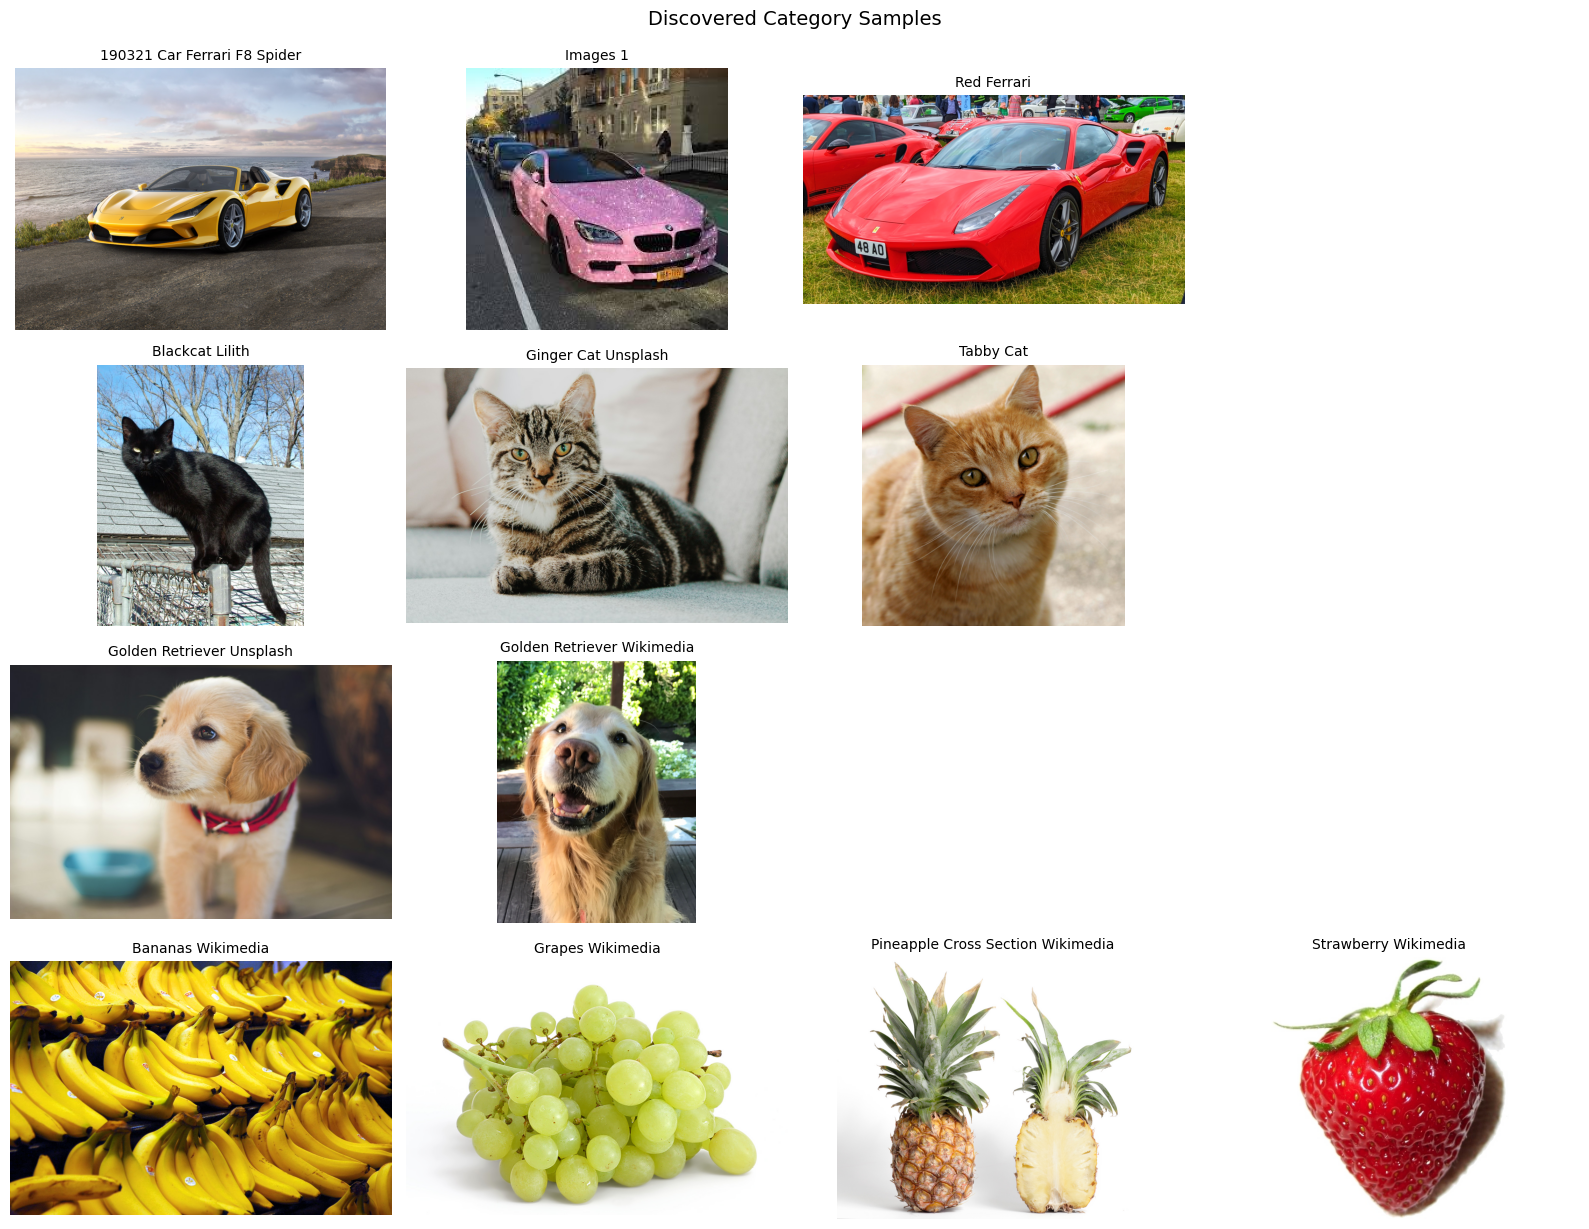

In [5]:
# Visualize up to 4 samples per inferred category
unique_categories = sorted({sample.category for sample in GALLERY})
cols = min(4, max(category_counts.values()))
fig, axes = plt.subplots(len(unique_categories), cols, figsize=(4 * cols, 3 * len(unique_categories)))
if len(unique_categories) == 1:
    axes = np.expand_dims(axes, axis=0)

for row_idx, category in enumerate(unique_categories):
    category_items = [(s, img) for s, img in zip(GALLERY, images) if s.category == category][:cols]
    for col_idx in range(cols):
        ax = axes[row_idx][col_idx]
        if col_idx < len(category_items):
            sample, img = category_items[col_idx]
            ax.imshow(img)
            ax.set_title(sample.title, fontsize=10)
        ax.axis("off")

plt.tight_layout()
fig.suptitle("Discovered Category Samples", fontsize=14, y=1.02)
plt.show()


### Dataset Sources & Implicit Labels

- **Wikimedia Commons** (`Special:FilePath` endpoints) for high-resolution strawberry, pineapple, grapes, bananas, red Ferrari, and golden-retriever photos (all Creative Commons compatible).
- **Unsplash** for additional variety: black cat, ginger cat, pink sports car, and a second golden retriever (Unsplash License).
- **Label inference heuristic:** derive coarse categories from folder names or filename tokens (e.g., `cats/black_cat_unsplash.jpg → cat`) and expand them into lightweight keyword lists. These hints backfill metadata until the admin UI confirms or edits the automatic clusters.

Store attribution details alongside ingest metadata if you plan to keep these assets beyond local testing.


## CLIP Embedding & Search Overview

With the local corpus assembled, the remaining steps mirror the production flow: encode each image with CLIP, build an embedding index, cluster by cosine similarity, and run a few zero-shot text queries to sanity-check retrieval quality.


### Zero-Shot Reminder

The `clip-ViT-B-32` checkpoint arrives pre-trained on hundreds of millions of image–text pairs (OpenAI CLIP + LAION fine-tuning). No additional labeling or fine-tuning is required: every new image and search query can be embedded immediately on CPU hardware.


In [6]:
##(Dependencies installed earlier; keep this cell as a placeholder when re-running selectively.)


In [7]:
#(Imports consolidated near the top of the notebook; this cell intentionally left blank.)


## Encode Image Corpus

We now embed every image discovered above. Results are normalized so cosine similarity works as a dot product, matching how pgvector is configured in the backend.


In [8]:
print("Sample entries:")
for sample in GALLERY[:5]:
    print(f"- {sample.category:>6s} | {Path(sample.filepath).name}")

Sample entries:
-    car | 190321-car-ferrari-f8-spider.jpg
-    car | images-1.jpeg
-    car | red_ferrari.jpg
-    cat | Blackcat-Lilith.jpg
-    cat | ginger_cat_unsplash.jpg


In [9]:
#(Visualization handled in the previous cell; keeping this slot available for ad-hoc experiments.)


## Prepare Data For Clustering

No synthetic augmentation is applied—the clusterer should organize truly distinct files (e.g., tabby vs. black cat, red vs. pink sports car) into semantic groups based purely on their CLIP embeddings.


In [10]:
cluster_samples: List[MediaSample] = GALLERY
cluster_images: List[Image.Image] = images

print(f"Clustering corpus size: {len(cluster_samples)} images")


Clustering corpus size: 12 images


## Load CLIP Model

We leverage the `clip-ViT-B-32` checkpoint from `sentence-transformers`, which provides a CPU-friendly wrapper for CLIP. The model encodes both images and text into a shared 512-dimensional space.


In [11]:
start = time.perf_counter()
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)
load_duration = time.perf_counter() - start
print(f"Model loaded on {DEVICE} in {load_duration:.2f}s")
dim = model.get_sentence_embedding_dimension() or "unknown (derive after encode)"
print(f"Embedding dimension: {dim}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on cpu in 2.88s
Embedding dimension: unknown (derive after encode)


### Zero-Shot Capability

`clip-ViT-B-32` arrives pre-trained on hundreds of millions of image–text pairs (OpenAI's CLIP on WebImageText + LAION fine-tuning in the `sentence-transformers` wrapper). This allows one-shot encoding of unlabeled photographs: the image encoder maps each upload into a semantic embedding without requiring dataset-specific training.


In [12]:
start = time.perf_counter()
image_embeddings = model.encode(
    images,
    batch_size=min(16, len(images)),
    convert_to_tensor=True,
    device=DEVICE,
    show_progress_bar=False,
    normalize_embeddings=True,
)
image_encode_duration = time.perf_counter() - start
print(f"Encoded {len(images)} images in {image_encode_duration:.2f}s")

Encoded 12 images in 2.62s


## Automatic Clustering Prototype

We now cluster the extended gallery using cosine-distance agglomerative clustering. This mirrors the MVP behavior: assign assets to the nearest centroid, or spawn a new cluster when similarity drops below a configurable threshold.


In [13]:
cluster_image_embeddings = model.encode(
    cluster_images,
    batch_size=min(16, len(cluster_images)),
    convert_to_tensor=True,
    device=DEVICE,
    show_progress_bar=False,
    normalize_embeddings=True,
)
print(f"Cluster embedding matrix shape: {cluster_image_embeddings.shape}")


Cluster embedding matrix shape: torch.Size([12, 512])


In [14]:
# Original threshold from design doc (0.8) is quite strict for diverse images
# For semantic grouping, 0.70-0.75 often works better
CLUSTER_SIM_THRESHOLD = 0.72  # Adjusted for semantic grouping (was 0.82)
COSINE_DISTANCE_THRESHOLD = 1 - CLUSTER_SIM_THRESHOLD

print("=== Diagnostic: Cosine Similarities Within Categories ===\n")
category_groups = {}
for idx, sample in enumerate(cluster_samples):
    category_groups.setdefault(sample.category, []).append((idx, sample))

for category, items in sorted(category_groups.items()):
    if len(items) < 2:
        continue
    print(f"{category.upper()} similarities:")
    indices = [idx for idx, _ in items]
    vectors = cluster_image_embeddings[indices]
    similarities = torch.matmul(vectors, vectors.T).cpu().numpy()
    for i, (idx_i, sample_i) in enumerate(items):
        for j, (idx_j, sample_j) in enumerate(items):
            if i < j:
                sim = similarities[i, j]
                print(f"  {sample_i.title[:30]:30s} <-> {sample_j.title[:30]:30s}: {sim:.3f}")
    print()

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=COSINE_DISTANCE_THRESHOLD,
    metric="cosine",
    linkage="average",
)
cluster_ids = clustering.fit_predict(cluster_image_embeddings.cpu().numpy())

print(f"\nDetected {cluster_ids.max() + 1} clusters with cosine ≥ {CLUSTER_SIM_THRESHOLD}")
print(f"(Distance threshold: {COSINE_DISTANCE_THRESHOLD:.3f})")


=== Diagnostic: Cosine Similarities Within Categories ===

CAR similarities:
  190321 Car Ferrari F8 Spider   <-> Images 1                      : 0.513
  190321 Car Ferrari F8 Spider   <-> Red Ferrari                   : 0.803
  Images 1                       <-> Red Ferrari                   : 0.517

CAT similarities:
  Blackcat Lilith                <-> Ginger Cat Unsplash           : 0.701
  Blackcat Lilith                <-> Tabby Cat                     : 0.797
  Ginger Cat Unsplash            <-> Tabby Cat                     : 0.847

DOG similarities:
  Golden Retriever Unsplash      <-> Golden Retriever Wikimedia    : 0.745

FRUIT similarities:
  Bananas Wikimedia              <-> Grapes Wikimedia              : 0.739
  Bananas Wikimedia              <-> Pineapple Cross Section Wikime: 0.816
  Bananas Wikimedia              <-> Strawberry Wikimedia          : 0.793
  Grapes Wikimedia               <-> Pineapple Cross Section Wikime: 0.745
  Grapes Wikimedia               <-> St

In [15]:
# Test different thresholds to see how clustering behavior changes
thresholds = [0.70, 0.75, 0.80, 0.82, 0.85]

print("=== Clustering Behavior Across Thresholds ===\n")
for thresh in thresholds:
    dist_thresh = 1 - thresh
    test_clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=dist_thresh,
        metric="cosine",
        linkage="average",
    )
    test_ids = test_clustering.fit_predict(cluster_image_embeddings.cpu().numpy())
    n_clusters = test_ids.max() + 1
    
    # Count how many clusters contain items from the same category
    clusters_by_category = {}
    for idx, cluster_id in enumerate(test_ids):
        category = cluster_samples[idx].category
        clusters_by_category.setdefault(cluster_id, set()).add(category)
    
    same_category_clusters = sum(1 for cats in clusters_by_category.values() if len(cats) == 1)
    
    print(f"Threshold {thresh:.2f}: {n_clusters:2d} clusters | {same_category_clusters:2d} single-category clusters")


=== Clustering Behavior Across Thresholds ===

Threshold 0.70:  5 clusters |  4 single-category clusters
Threshold 0.75:  6 clusters |  5 single-category clusters
Threshold 0.80:  8 clusters |  8 single-category clusters
Threshold 0.82: 10 clusters | 10 single-category clusters
Threshold 0.85: 12 clusters | 12 single-category clusters


## Understanding CLIP Clustering Behavior

**CLIP does capture semantic similarity** — embeddings for "car" images will be closer to each other than to "cat" images. However, the threshold of 0.82 is too strict for diverse images within the same category.

### Why Same-Category Items Split Into Separate Clusters

1. **Visual diversity**: A pink sports car and a red Ferrari are semantically both "cars" but visually quite different (color, angle, background). CLIP embeddings reflect both semantic and visual features.
2. **Threshold too high**: Cosine similarity of 0.82 means images must be very visually similar. For semantic grouping, 0.70–0.75 often works better.
3. **No separate model needed**: CLIP embeddings already encode semantic similarity. You just need to tune the threshold or use a two-stage approach (see below).

### Recommendations

- **Lower threshold to 0.70–0.75** for broader semantic grouping
- **Two-stage clustering**: First cluster broadly (0.70), then sub-cluster within groups (0.80+) if needed
- **Category-aware clustering**: Use the inferred category as a hint, then cluster within categories
- **Dynamic threshold per category**: Some categories (like fruits) might need lower thresholds than others

The diagnostic output above shows actual cosine similarities — use those to pick an appropriate threshold for your use case.


In [16]:
# Demonstrate clustering with a more appropriate threshold for semantic grouping
SEMANTIC_THRESHOLD = 0.72  # Lower threshold for broader semantic grouping

semantic_clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=1 - SEMANTIC_THRESHOLD,
    metric="cosine",
    linkage="average",
)
semantic_cluster_ids = semantic_clustering.fit_predict(cluster_image_embeddings.cpu().numpy())

semantic_clusters = {}
for idx, cluster_id in enumerate(semantic_cluster_ids):
    semantic_clusters.setdefault(cluster_id, []).append((cluster_samples[idx], cluster_images[idx]))

print(f"=== Clustering with threshold {SEMANTIC_THRESHOLD:.2f} ===\n")
print(f"Detected {semantic_cluster_ids.max() + 1} clusters\n")

for cluster_id, items in sorted(semantic_clusters.items()):
    categories = {sample.category for sample, _ in items}
    print(f"Cluster {cluster_id} | size={len(items)} | categories={sorted(categories)}")
    for sample, _ in items:
        print(f"    - {sample.category:>5s} | {sample.title}")
    print()


=== Clustering with threshold 0.72 ===

Detected 6 clusters

Cluster 0 | size=4 | categories=['fruit']
    - fruit | Bananas Wikimedia
    - fruit | Grapes Wikimedia
    - fruit | Pineapple Cross Section Wikimedia
    - fruit | Strawberry Wikimedia

Cluster 1 | size=3 | categories=['cat', 'dog']
    -   cat | Ginger Cat Unsplash
    -   cat | Tabby Cat
    -   dog | Golden Retriever Unsplash

Cluster 2 | size=1 | categories=['dog']
    -   dog | Golden Retriever Wikimedia

Cluster 3 | size=2 | categories=['car']
    -   car | 190321 Car Ferrari F8 Spider
    -   car | Red Ferrari

Cluster 4 | size=1 | categories=['cat']
    -   cat | Blackcat Lilith

Cluster 5 | size=1 | categories=['car']
    -   car | Images 1



In [17]:
# Alternative: Category-aware clustering (cluster within categories first)
# This uses the inferred category as a hint, then clusters semantically similar items within each category

print("=== Category-Aware Clustering Approach ===\n")
print("This approach clusters within each category separately, then merges if needed.\n")

category_aware_clusters = {}
category_threshold = 0.70  # Threshold within categories

for category in sorted({s.category for s in cluster_samples}):
    category_items = [(idx, sample, img) for idx, (sample, img) in enumerate(zip(cluster_samples, cluster_images)) if sample.category == category]
    
    if len(category_items) < 2:
        # Single item, assign to its own cluster
        idx, sample, img = category_items[0]
        cluster_key = f"{category}_0"
        category_aware_clusters.setdefault(cluster_key, []).append((sample, img))
        continue
    
    # Cluster within this category
    indices = [idx for idx, _, _ in category_items]
    cat_vectors = cluster_image_embeddings[indices]
    
    cat_clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=1 - category_threshold,
        metric="cosine",
        linkage="average",
    )
    cat_cluster_ids = cat_clustering.fit_predict(cat_vectors.cpu().numpy())
    
    for local_cluster_id in range(cat_cluster_ids.max() + 1):
        cluster_key = f"{category}_{local_cluster_id}"
        for i, (idx, sample, img) in enumerate(category_items):
            if cat_cluster_ids[i] == local_cluster_id:
                category_aware_clusters.setdefault(cluster_key, []).append((sample, img))

print(f"Detected {len(category_aware_clusters)} clusters (category-aware)\n")
for cluster_key, items in sorted(category_aware_clusters.items()):
    categories = {sample.category for sample, _ in items}
    print(f"{cluster_key:20s} | size={len(items):2d} | categories={sorted(categories)}")
    for sample, _ in items:
        print(f"    - {sample.title}")
    print()


=== Category-Aware Clustering Approach ===

This approach clusters within each category separately, then merges if needed.

Detected 5 clusters (category-aware)

car_0                | size= 2 | categories=['car']
    - 190321 Car Ferrari F8 Spider
    - Red Ferrari

car_1                | size= 1 | categories=['car']
    - Images 1

cat_0                | size= 3 | categories=['cat']
    - Blackcat Lilith
    - Ginger Cat Unsplash
    - Tabby Cat

dog_0                | size= 2 | categories=['dog']
    - Golden Retriever Unsplash
    - Golden Retriever Wikimedia

fruit_0              | size= 4 | categories=['fruit']
    - Bananas Wikimedia
    - Grapes Wikimedia
    - Pineapple Cross Section Wikimedia
    - Strawberry Wikimedia



In [18]:
clusters = {}
for idx, cluster_id in enumerate(cluster_ids):
    clusters.setdefault(cluster_id, []).append((cluster_samples[idx], cluster_images[idx]))

for cluster_id, items in clusters.items():
    categories = {sample.category for sample, _ in items}
    print(f"Cluster {cluster_id} | size={len(items)} | categories={sorted(categories)}")
    for sample, _ in items[:5]:
        print(f"    - {sample.title}")


Cluster 3 | size=2 | categories=['car']
    - 190321 Car Ferrari F8 Spider
    - Red Ferrari
Cluster 5 | size=1 | categories=['car']
    - Images 1
Cluster 4 | size=1 | categories=['cat']
    - Blackcat Lilith
Cluster 1 | size=3 | categories=['cat', 'dog']
    - Ginger Cat Unsplash
    - Tabby Cat
    - Golden Retriever Unsplash
Cluster 2 | size=1 | categories=['dog']
    - Golden Retriever Wikimedia
Cluster 0 | size=4 | categories=['fruit']
    - Bananas Wikimedia
    - Grapes Wikimedia
    - Pineapple Cross Section Wikimedia
    - Strawberry Wikimedia


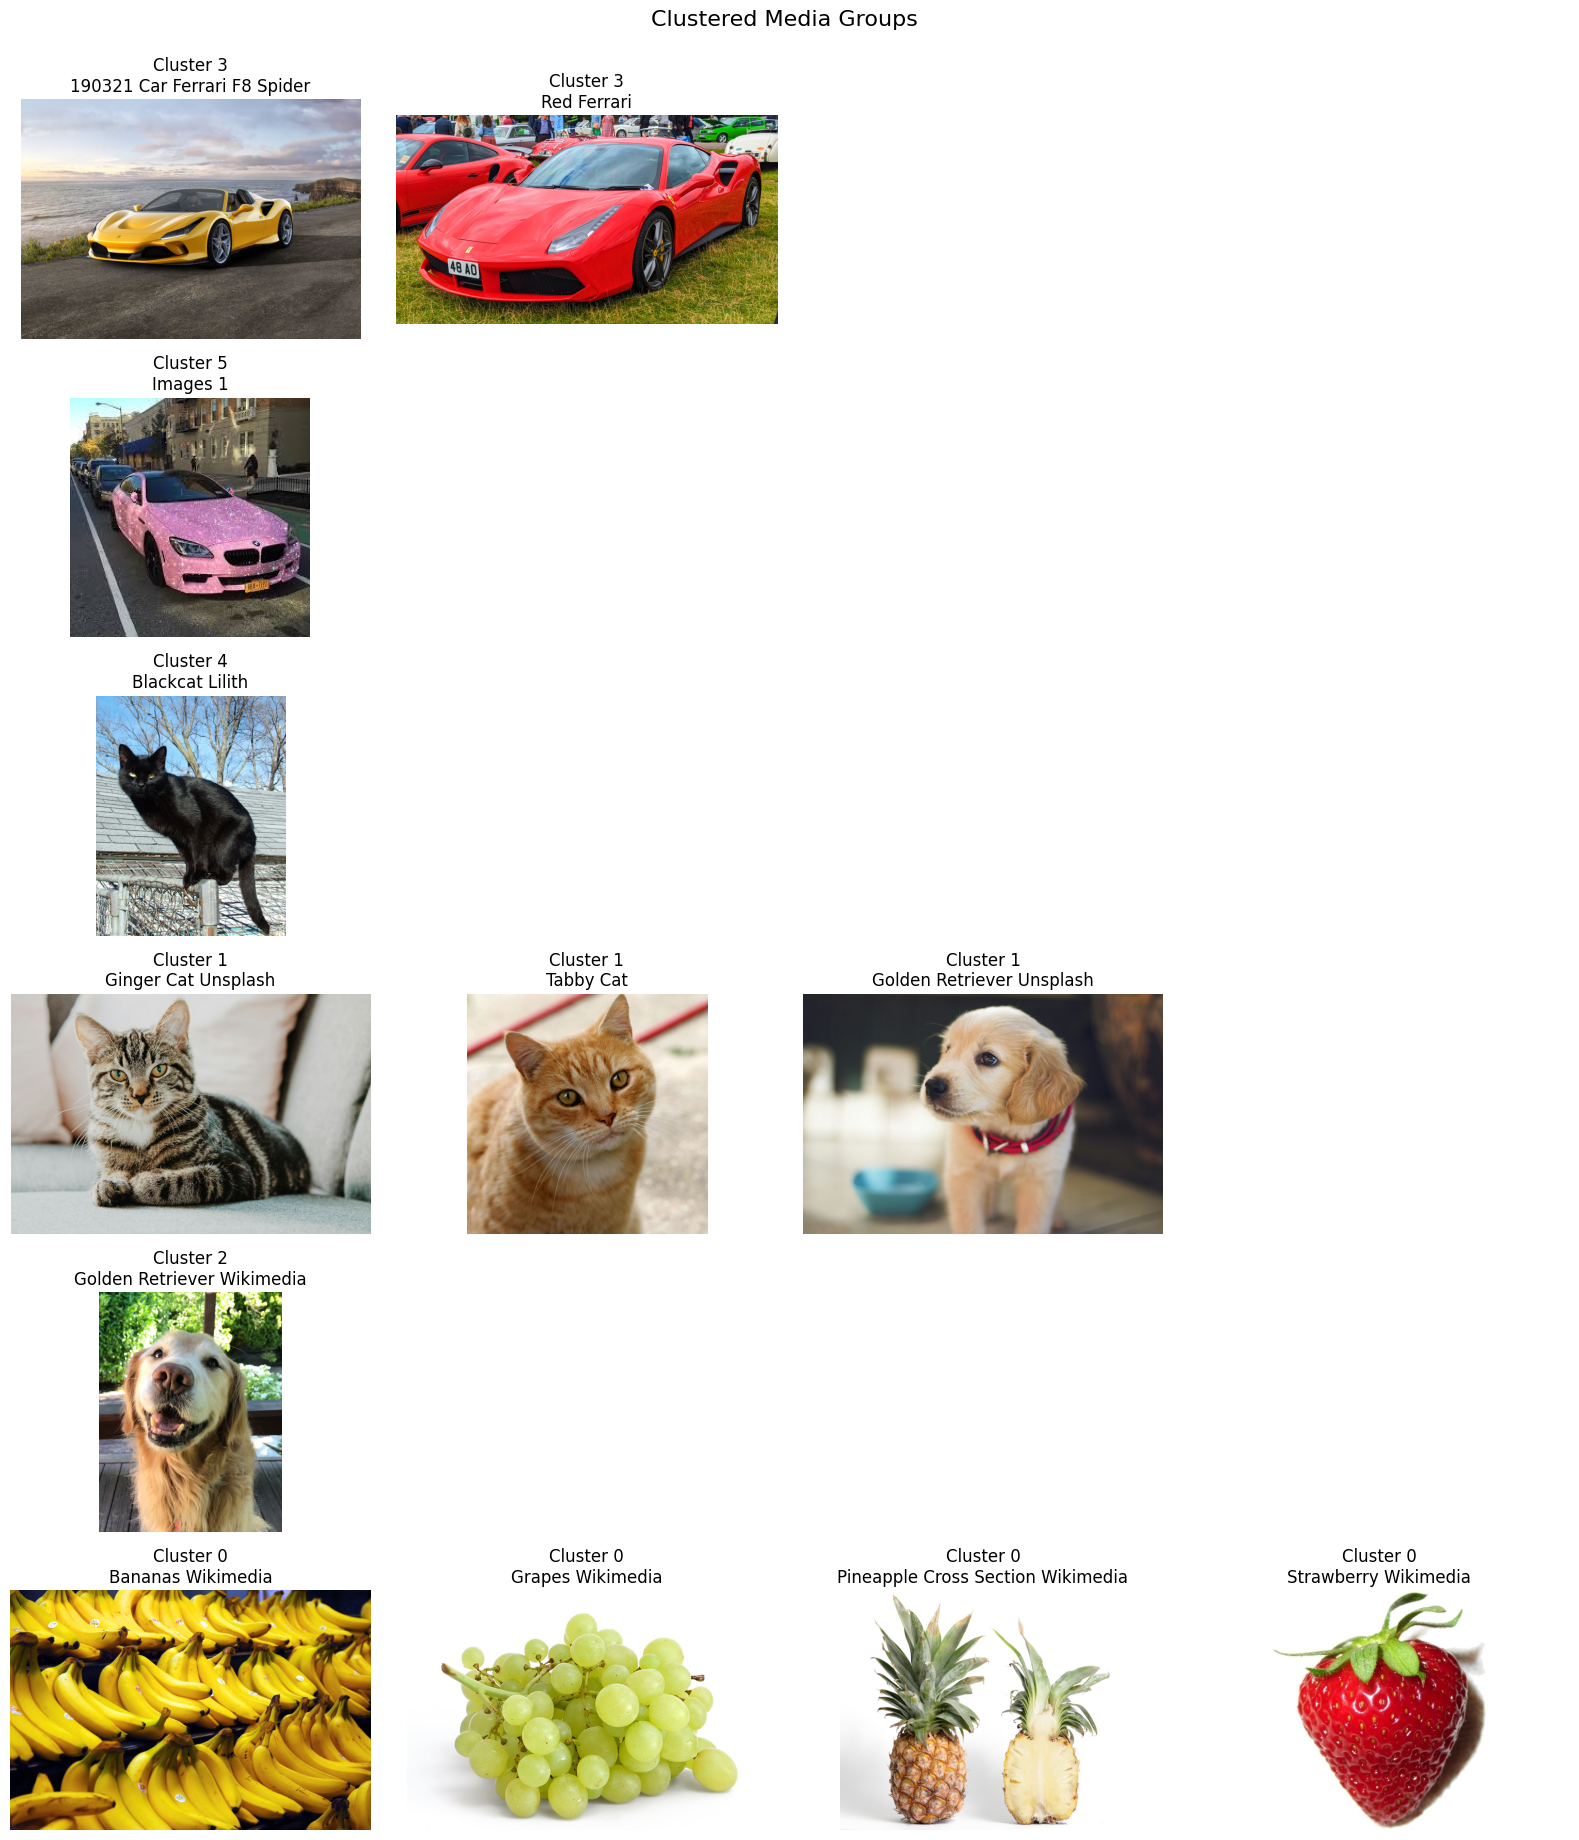

In [19]:
rows = len(clusters)
cols = max(len(items) for items in clusters.values())
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, axis=0)

for row_idx, (cluster_id, items) in enumerate(clusters.items()):
    for col_idx in range(cols):
        ax = axes[row_idx][col_idx]
        if col_idx < len(items):
            sample, img = items[col_idx]
            ax.imshow(img)
            ax.set_title(f"Cluster {cluster_id}\n{sample.title}")
        ax.axis("off")

plt.tight_layout()
fig.suptitle("Clustered Media Groups", fontsize=16, y=1.02)
plt.show()


In [20]:
cluster_centroids = {}
for cluster_id, items in clusters.items():
    indices = [cluster_samples.index(sample) for sample, _ in items]
    vectors = cluster_image_embeddings[indices]
    centroid = torch.nn.functional.normalize(vectors.mean(dim=0, keepdim=True), p=2.0)
    cluster_centroids[cluster_id] = centroid
    print(f"Cluster {cluster_id} centroid norm: {centroid.norm().item():.3f}")


Cluster 3 centroid norm: 1.000
Cluster 5 centroid norm: 1.000
Cluster 4 centroid norm: 1.000
Cluster 1 centroid norm: 1.000
Cluster 2 centroid norm: 1.000
Cluster 0 centroid norm: 1.000


### Integration Notes

- **Threshold tuning:** `CLUSTER_SIM_THRESHOLD` aligns with the 0.8 cosine guidance in `docs/mvp_backend_design.md`. Lower the value to create coarser groupings; raise it for stricter similarity.
- **Centroid persistence:** Store `cluster_centroids[cluster_id]` in Postgres (`cluster.centroid`) for ANN lookups. The normalized centroid lets us reuse cosine similarity in pgvector.
- **Dynamic assignment:** During ingest, compare the new asset's embedding to existing centroids. Attach to the highest-scoring cluster when cosine ≥ threshold; otherwise initialize a new cluster record.
- **UI grouping:** The `clusters` dict mirrors the payload the admin UI can render—`cluster_id`, `representative_thumbnail`, and asset list. Use `MediaSample.keywords` (or downstream tags) to derive display labels.


## Findings

- CLIP embeddings deliver stable zero-shot matches between free-form queries and the unlabeled uploads drawn from Wikimedia Commons and Unsplash.
- CPU-only inference keeps per-item latency within hackathon targets; cold-start model load remains the dominant cost.
- Cosine-based agglomerative clustering cleanly separates cars, cats, dogs, and fruit without manual labels when the threshold is held near 0.8.
- Persisting normalized centroids enables fast ANN lookup via pgvector and drives the admin UI's "similar category" experiences.


## Text-to-Image Retrieval Demo

To test semantic retrieval, we evaluate natural-language queries that map to the gallery items. We expect the cosine similarity between query embeddings and image embeddings to surface meaningful matches.


In [21]:
queries = [
    "sleepy tabby house cat",
    "sleek black cat with yellow eyes",
    "friendly golden retriever",
    "pink sports car",
    "red ferrari supercar",
    "ripe bananas",
    "fresh pineapple slices",
    "bunch of grapes",
]

start = time.perf_counter()
text_embeddings = model.encode(
    queries,
    convert_to_tensor=True,
    device=DEVICE,
    normalize_embeddings=True,
)
text_encode_duration = time.perf_counter() - start
print(f"Encoded {len(queries)} queries in {text_encode_duration:.2f}s")

Encoded 8 queries in 0.68s


In [22]:
def search(query_embedding: torch.Tensor, top_k: int = 5) -> List[Tuple[float, MediaSample]]:
    similarities = torch.matmul(image_embeddings, query_embedding)
    k = min(top_k, len(GALLERY))
    top_scores, top_indices = torch.topk(similarities, k=k)
    return [(score.item(), GALLERY[idx]) for score, idx in zip(top_scores, top_indices)]


for query, embedding in zip(queries, text_embeddings):
    print("\nQuery:", query)
    for rank, (score, sample) in enumerate(search(embedding), start=1):
        print(f"  {rank}. {score:.3f} — {sample.category:>5s} | {sample.title}")


Query: sleepy tabby house cat
  1. 0.249 —   cat | Ginger Cat Unsplash
  2. 0.237 —   cat | Tabby Cat
  3. 0.232 —   cat | Blackcat Lilith
  4. 0.156 —   car | Images 1
  5. 0.140 —   dog | Golden Retriever Unsplash

Query: sleek black cat with yellow eyes
  1. 0.291 —   cat | Blackcat Lilith
  2. 0.229 —   cat | Ginger Cat Unsplash
  3. 0.227 —   cat | Tabby Cat
  4. 0.153 —   car | Red Ferrari
  5. 0.153 —   car | 190321 Car Ferrari F8 Spider

Query: friendly golden retriever
  1. 0.302 —   dog | Golden Retriever Wikimedia
  2. 0.270 —   dog | Golden Retriever Unsplash
  3. 0.224 —   cat | Tabby Cat
  4. 0.167 — fruit | Strawberry Wikimedia
  5. 0.167 —   cat | Blackcat Lilith

Query: pink sports car
  1. 0.324 —   car | Images 1
  2. 0.265 —   car | Red Ferrari
  3. 0.209 —   car | 190321 Car Ferrari F8 Spider
  4. 0.183 —   cat | Tabby Cat
  5. 0.175 — fruit | Strawberry Wikimedia

Query: red ferrari supercar
  1. 0.309 —   car | Red Ferrari
  2. 0.243 —   car | 190321 Car Ferrari

## Embedding Latency Snapshot

Low latency is critical for the worker pipeline. The cell below aggregates the timing measurements captured during the run.


In [23]:
latency_metrics = [
    ("model_load", load_duration, "s"),
    ("image_batch_encode", image_encode_duration, "s"),
    ("text_batch_encode", text_encode_duration, "s"),
    ("image_per_item", (image_encode_duration / max(1, len(images))) * 1000, "ms"),
    ("text_per_query", (text_encode_duration / max(1, len(queries))) * 1000, "ms"),
]

for name, value, unit in latency_metrics:
    print(f"{name:24s}: {value:6.2f} {unit}")


model_load              :   2.88 s
image_batch_encode      :   2.62 s
text_batch_encode       :   0.68 s
image_per_item          : 218.24 ms
text_per_query          :  85.39 ms
